# bacis case

In [1]:
from pyomo.environ import *
import numpy as np
import matplotlib.pyplot as plt
import bisect
from pyomo.opt import SolverStatus, TerminationCondition

In [2]:
def evaluate_Q_at(model, y_val, solver):
    """
    Given y = y_val , minimize obj_expr and return v(y).
    This function temporarily increments the objective and clears it after completion, without changing the model structure.
    """
    # Clear any remaining As/pw/obj (to prevent it from being left over from the previous round)
    for comp in ['obj', 'As', 'pw']:
        if hasattr(model, comp):
            model.del_component(comp)

    # Fix y, create a temporary target and solve
    model.y.fix(y_val)
    model.obj = Objective(expr=model.obj_expr, sense=minimize)
    results = solver.solve(model, tee=False)

    status_ok = (results.solver.status == SolverStatus.ok)
    term_ok = (results.solver.termination_condition == TerminationCondition.optimal)
    if not (status_ok and term_ok):
        # check if solution okay
        raise RuntimeError(f"Scenario evaluate at y={y_val} not optimal: "
                           f"status={results.solver.status}, term={results.solver.termination_condition}")

    v_y = value(model.obj_expr)
    # clear temporarily objective
    model.del_component('obj')
    model.y.unfix()
    return v_y

def nc_underest(bounds, model_list, add_node_num, picture_shown=False, v_list=False, tolerance=1e-8):
    """
    Parameters:
        bounds (list): contains 2 float which is lower and upper bound of variable
        model (list): model with submodels corresponds to each scenario
        add_node_num (float): number of sample nodes
        tolerance (float): decide when to stop

    Returns: delta (float): delta
             errors (float): hausdorff error
             y_nodes (list): y node (to make plot)
             as_nodes_list[0] (list): As node value (to make plot)
             ms_list[0] (float): ms for first scenario (to make plot)
    """
    N = len(model_list) 
    new_lb = bounds[0]
    new_ub = bounds[1]
    eff_node_count = 0 #  count how many extra nodes were actually added
    as_nodes_list = [None] * N
    ms_list = [None] * N
    new_nodes_list = [None] * N # Storing potential new nodes
    As_min_list = []
    under_tol = 1e-8

    # set up solver
    solver = SolverFactory('gurobi')
    solver.options['FeasibilityTol'] = 1e-09
    solver.options['OptimalityTol'] = 1e-09
    solver.options['NonConvex'] = 2 
    
    ######### if we want to plot figures#########
    if picture_shown:
        y_vals = np.linspace(new_lb, new_ub, 100)
        Qs_vals_list = [None] * N
        for i in range(N):
            Qs_vals_list[i] = [v_list[i](y) for y in y_vals]
        Qs_arr = np.array(Qs_vals_list, dtype=float, ndmin=2)  
        Qs_vals_sum = Qs_arr.sum(axis=0)
    #############################################
    
    # start with 2 nodes
    #y_nodes = bounds
    y_nodes = [bounds[0],bounds[1]]
    for i in range(N):
        as_nodes_list[i] = [evaluate_Q_at(model_list[i], new_lb, solver),evaluate_Q_at(model_list[i], new_ub, solver)]
    # reset bounds
    for i in range(N):
        model_list[i].y.setlb(new_lb)
        model_list[i].y.setub(new_ub)
    
    print('The goal is to get ',add_node_num,' nodes')
    for k in range(3,add_node_num+1):
        print('##################################################')
        print('##################################################')
        print('Start adding node ',k)
        for i in range(N):
            print(' ')
            print('Solving scenario ',i)
            # define piecewise function for each scenario
            for comp in ['obj', 'As', 'pw']:
                if hasattr(model_list[i], comp):
                    model_list[i].del_component(comp)
            model_list[i].As = Var()
            model_list[i].pw = Piecewise(
                model_list[i].As, model_list[i].y,
                pw_pts=y_nodes,
                f_rule=as_nodes_list[i],
                pw_constr_type='EQ',
                pw_repn='SOS2'
            )

            # set up objective for each scenario and solve
            model_list[i].obj = Objective(expr=model_list[i].obj_expr - model_list[i].As, sense=minimize)
            results = solver.solve(model_list[i])
            
            if (results.solver.status != SolverStatus.ok) or \
               (results.solver.termination_condition != TerminationCondition.optimal):
                print("⚠ There may be problems with the solution")
                
            ms_list[i] = value(model_list[i].obj)
            # insert new nodes
            new_nodes_list[i] = value(model_list[i].y)
            
            if picture_shown:
                print(' ')
                print('The plot for scenario ',i)
                print('The potential y_star is ',value(model_list[i].y))
                print('ms is ',value(model_list[i].obj))
                # set up plot parameters
                y_nodes_arr = np.array(y_nodes)
                as_nodes_arr = np.array(as_nodes_list[i])
                y_star_i = value(model_list[i].y)
                ms_i = value(model_list[i].obj)
                ## plot the figure
                plt.figure(figsize=(8, 5))
                plt.plot(y_vals, Qs_vals_list[i], label=fr'$Qs_{i}$', color='red')
                plt.plot(y_nodes_arr, as_nodes_arr+ms_i,label=fr'$As_{i} underest$',color='red', marker='o',linestyle='--',alpha=0.5)
                plt.plot(y_nodes_arr, as_nodes_arr,label=fr'$As_{i}$',color='blue', marker='o',linestyle='--',alpha=0.5)
                plt.axvline(x=y_star_i, color='purple', linestyle='--')
                plt.xlim(new_lb, new_ub)
                plt.xlabel('y')
                plt.ylabel('value')
                plt.title(fr"Plot for scenario {i} for {k} nodes")
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()
        ##################################################

        # define and solve the sum model
        arr = np.array(as_nodes_list, dtype=float, ndmin=2)  
        assum_nodes = arr.sum(axis=0)    
        
        model_sum = ConcreteModel()
        model_sum.y = Var(bounds=(new_lb, new_ub))
        model_sum.As = Var()
        model_sum.pw = Piecewise(
            model_sum.As, model_sum.y,
            pw_pts=y_nodes,
            f_rule=list(assum_nodes),
            pw_constr_type='EQ',
            pw_repn='SOS2'
        )
        #eps_local = 1e-6
        #model_sum.obj = Objective(expr = model_sum.As + eps_local*model_sum.y**2, sense=minimize)
        model_sum.obj = Objective(expr = model_sum.As, sense=minimize)
        results = solver.solve(model_sum)
        if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
            pass
        else:
            print("Sum model doesn't get solved normally")
        # get the output
        As_min = results.problem.lower_bound
        y_star = value(model_sum.y, exception=False)   
        if y_star is None:
            y_star = 0.5*(new_lb + new_ub)
        errors_y_star = 0
        for i in range(N):
            errors_y_star += evaluate_Q_at(model_list[i], y_star, solver)
        errors_y_star = abs(As_min - errors_y_star)
        
        
        if picture_shown:
            print(' ')
            print('The plot for As_sum')
            print('The potential y_star is ',y_star)
            print('error is ',errors_y_star)
            # set up plot parameters
            y_nodes_arr = np.array(y_nodes)
            assum_nodes_arr = np.array(assum_nodes)
            ms_sum = sum(ms_list)
            ## plot the figure
            plt.figure(figsize=(8, 5))
            plt.plot(y_vals, Qs_vals_sum, label=fr'$Qs_sum$', color='red')
            plt.plot(y_nodes_arr, assum_nodes_arr+ms_sum,label=fr'$As_sum underest$',color='red', marker='o',linestyle='--',alpha=0.5)
            plt.plot(y_nodes_arr, assum_nodes_arr,label=fr'$As_sum$',color='blue', marker='o',linestyle='--',alpha=0.5)
            plt.axvline(x=y_star, color='purple', linestyle='--')
            plt.xlim(new_lb, new_ub)
            plt.xlabel('y')
            plt.ylabel('value')
            plt.title(fr"Plot for As_sum for {k} nodes")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        sum_ms = abs(sum(ms_i for ms_i in ms_list))
        
        print('*****************************************')
        print('error at y_star is ',errors_y_star)
        print('y_star is ',y_star)
        print('ms_list and sum_ms is ',ms_list,sum_ms)
        if errors_y_star > sum_ms:
            new_node = y_star
            print('new node choosen from error')
        else:
            min_index = np.argmin(ms_list)
            new_node = new_nodes_list[min_index]
            print('new node choosen from ms')
        print('new node is',new_node)
        print('*****************************************')
        print('')
        As_min_list.append(As_min+sum_ms)
        #######################################################              

        if (new_node not in y_nodes) and (k != add_node_num):
            idx = bisect.bisect_left(y_nodes, new_node)
            y_nodes.insert(idx, new_node)
            for i in range(N):
                as_nodes_list[i].insert(idx, evaluate_Q_at(model_list[i], new_node, solver))
            eff_node_count += 1
                


    # define and solve the sum model
    assum_nodes = np.sum(as_nodes_list, axis=0)
    model_sum = ConcreteModel()
    model_sum.y = Var(bounds=(new_lb, new_ub))
    model_sum.As = Var()
    model_sum.pw = Piecewise(
        model_sum.As, model_sum.y,
        pw_pts=y_nodes,
        f_rule=list(assum_nodes),
        pw_constr_type='EQ',
        pw_repn='SOS2'
    )
    model_sum.obj = Objective(expr = model_sum.As, sense=minimize)
    results = solver.solve(model_sum)
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        pass
    else:
        print("Sum model doesn't get solved normally")
    # get the output
    output_lb = results.problem.lower_bound + sum(ms_list)
    
    # calculate the diameter
    delta = (new_ub-new_lb)/2
    
    return delta, output_lb, y_nodes, [range(3,add_node_num+1), As_min_list]

The goal is to get  20  nodes
##################################################
##################################################
Start adding node  3
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  -0.2
ms is  0.0


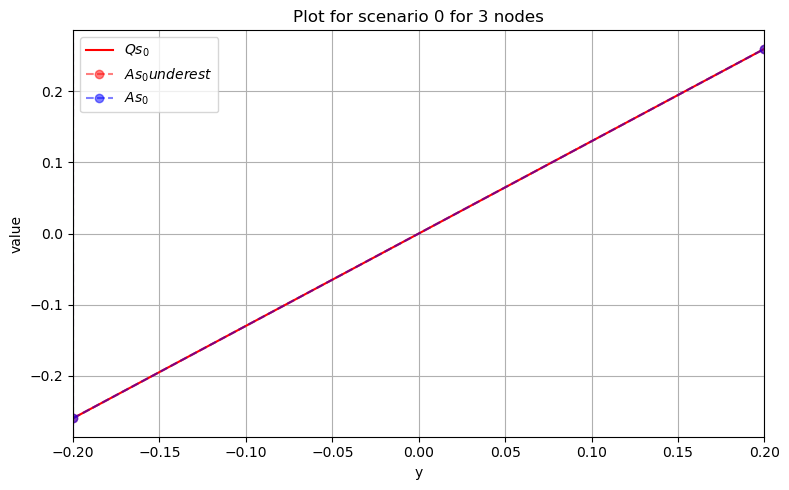

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  1.1102230246251565e-16
ms is  -0.03999999999999998


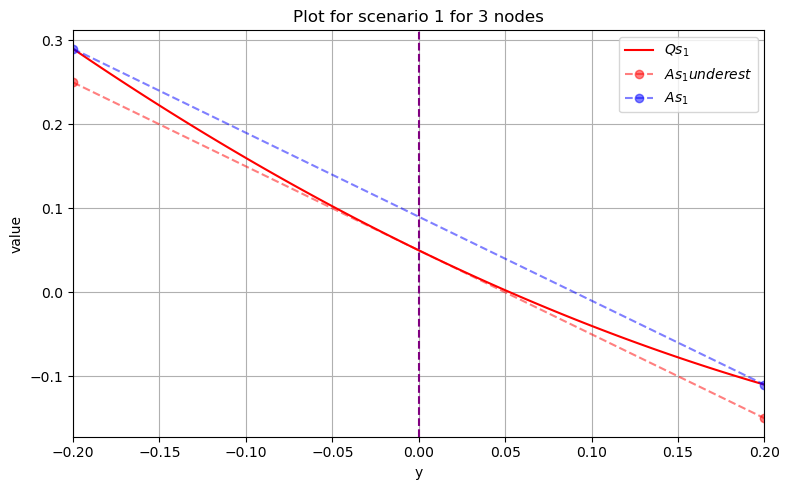

 
The plot for As_sum
The potential y_star is  -0.2
error is  6.938893903907228e-18


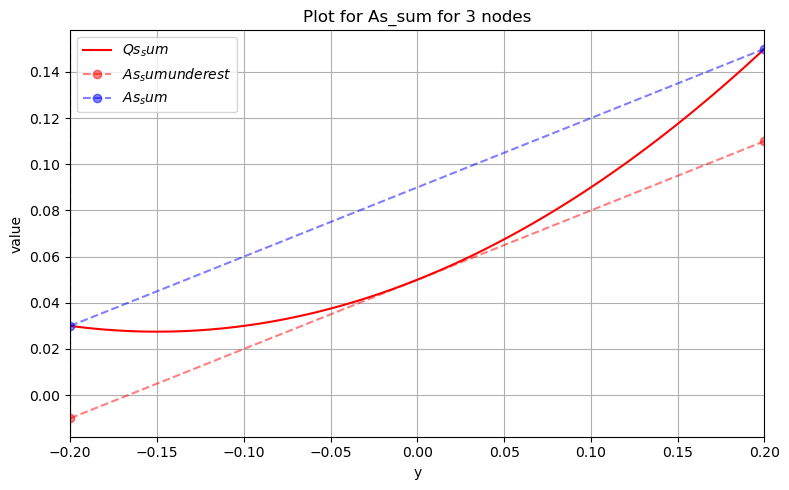

*****************************************
error at y_star is  6.938893903907228e-18
y_star is  -0.2
ms_list and sum_ms is  [0.0, -0.03999999999999998] 0.03999999999999998
new node choosen from ms
new node is 1.1102230246251565e-16
*****************************************

##################################################
##################################################
Start adding node  4
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  0.0
ms is  0.0


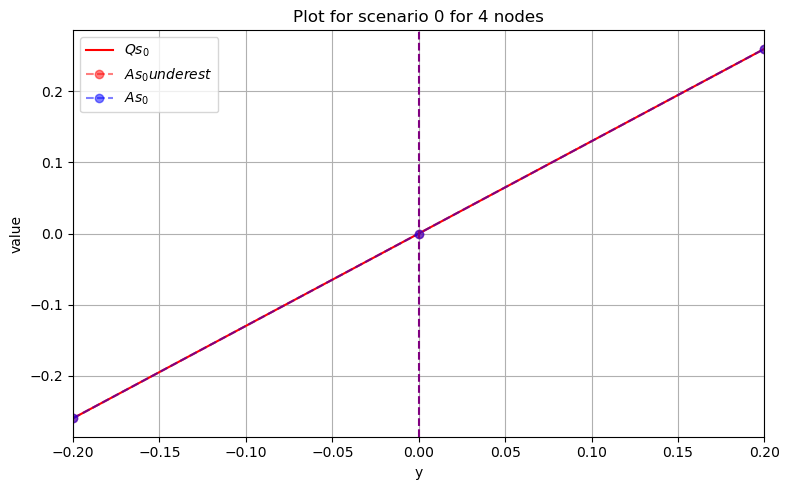

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.1
ms is  -0.009999999999999926


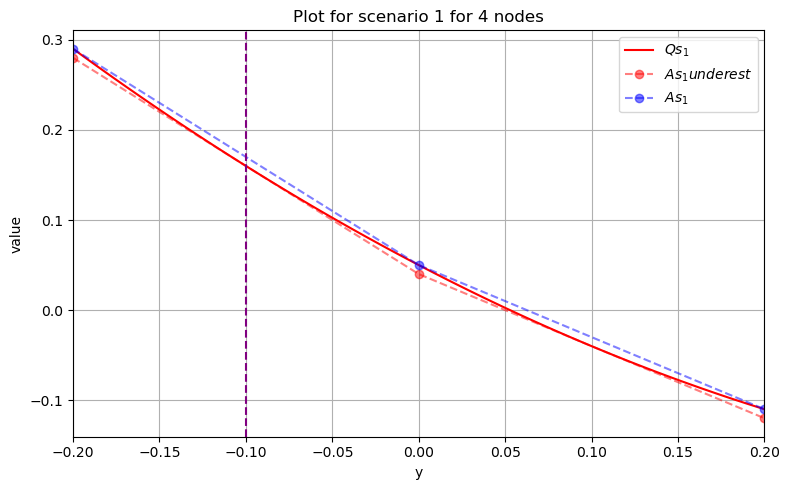

 
The plot for As_sum
The potential y_star is  -0.2
error is  0.0


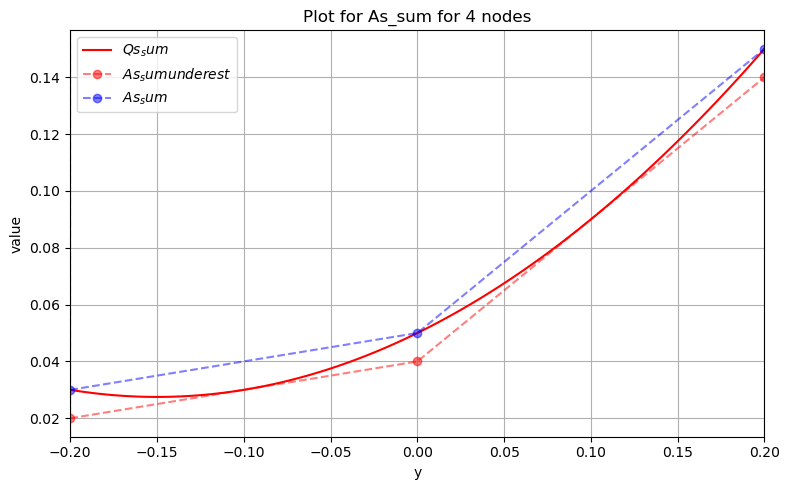

*****************************************
error at y_star is  0.0
y_star is  -0.2
ms_list and sum_ms is  [0.0, -0.009999999999999926] 0.009999999999999926
new node choosen from ms
new node is -0.1
*****************************************

##################################################
##################################################
Start adding node  5
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.1
ms is  0.0


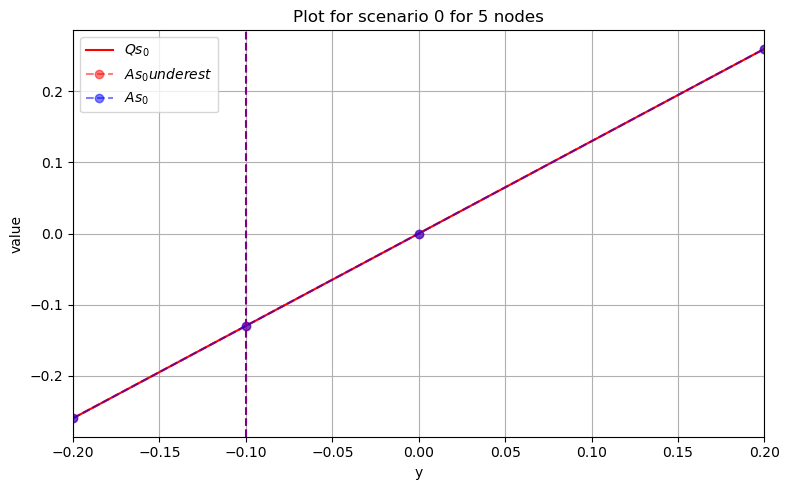

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  0.1
ms is  -0.009999999999999936


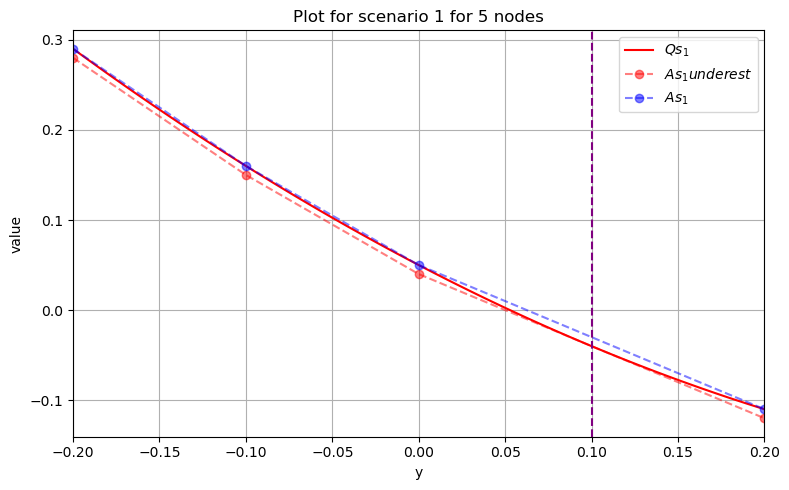

 
The plot for As_sum
The potential y_star is  -0.1
error is  0.0


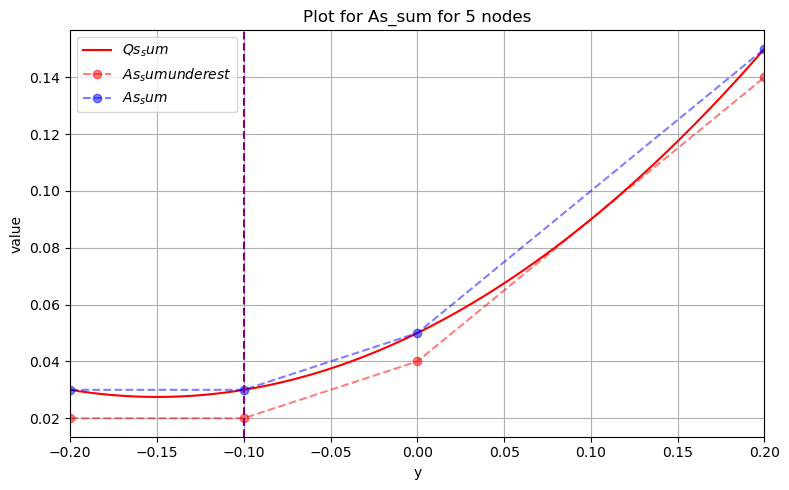

*****************************************
error at y_star is  0.0
y_star is  -0.1
ms_list and sum_ms is  [0.0, -0.009999999999999936] 0.009999999999999936
new node choosen from ms
new node is 0.1
*****************************************

##################################################
##################################################
Start adding node  6
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.1
ms is  0.0


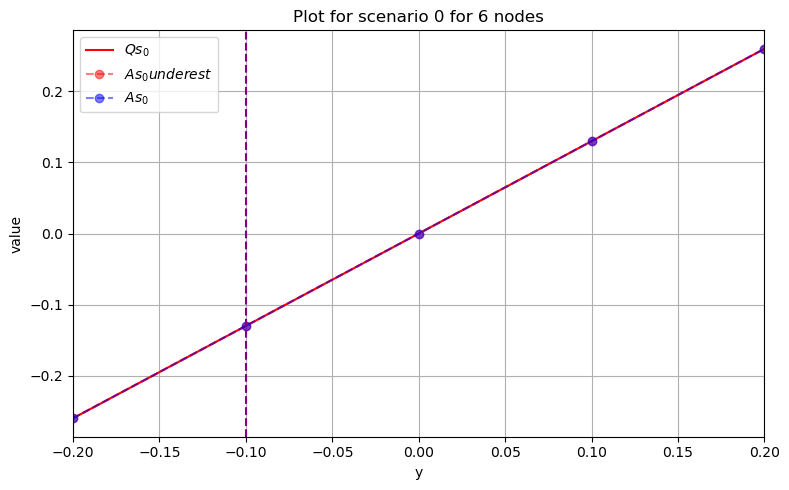

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.15
ms is  -0.0024999999999999467


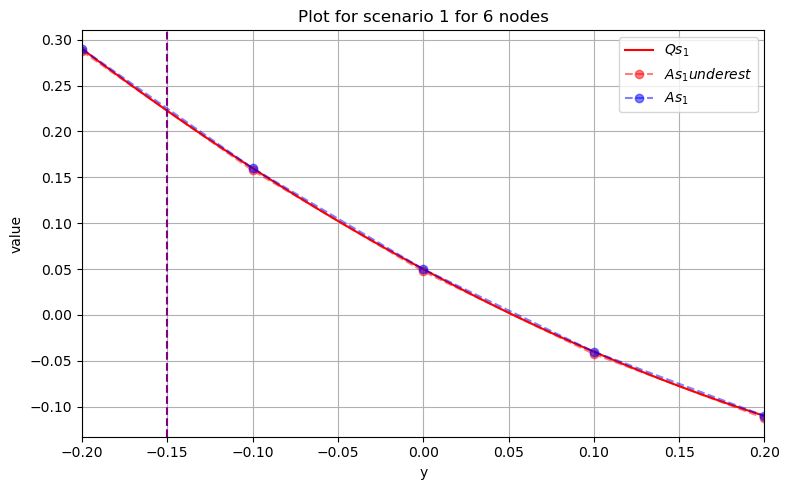

 
The plot for As_sum
The potential y_star is  -0.2
error is  0.0


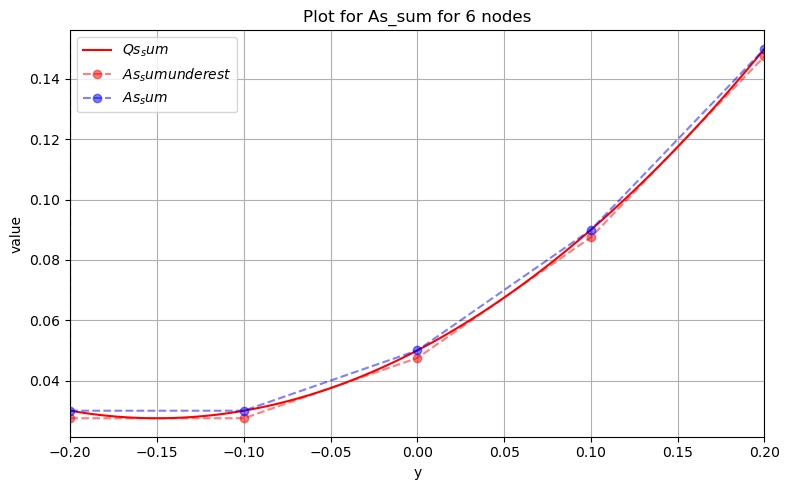

*****************************************
error at y_star is  0.0
y_star is  -0.2
ms_list and sum_ms is  [0.0, -0.0024999999999999467] 0.0024999999999999467
new node choosen from ms
new node is -0.15
*****************************************

##################################################
##################################################
Start adding node  7
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.15
ms is  0.0


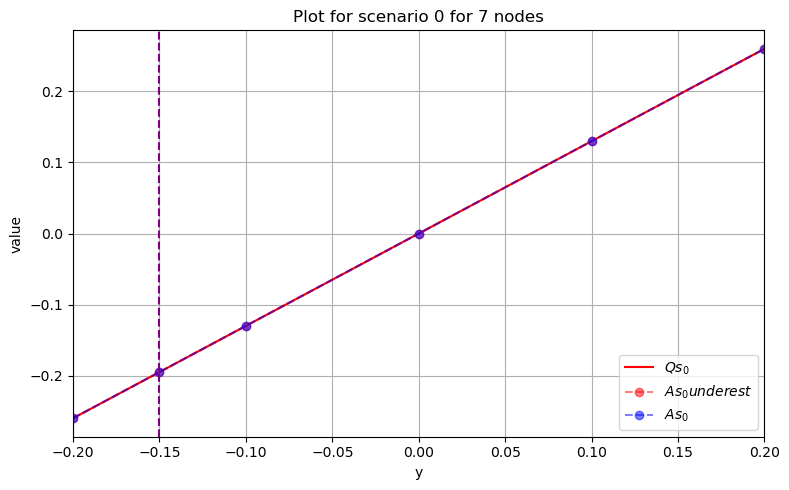

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  0.05
ms is  -0.0024999999999999745


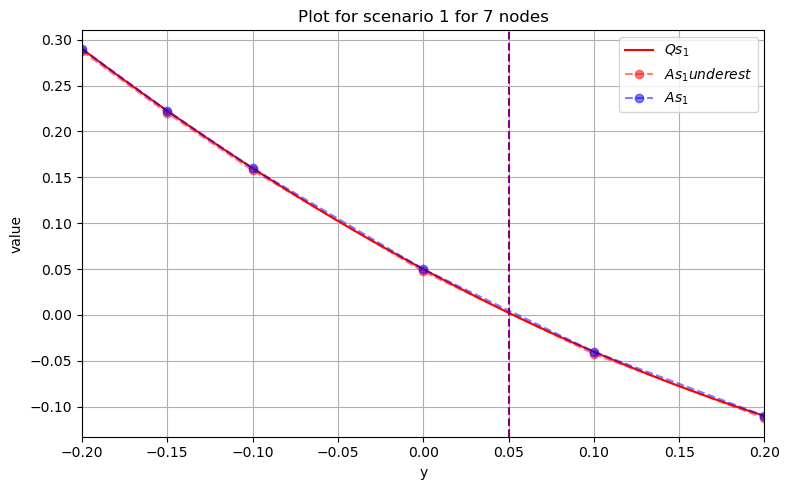

 
The plot for As_sum
The potential y_star is  -0.15
error is  0.0


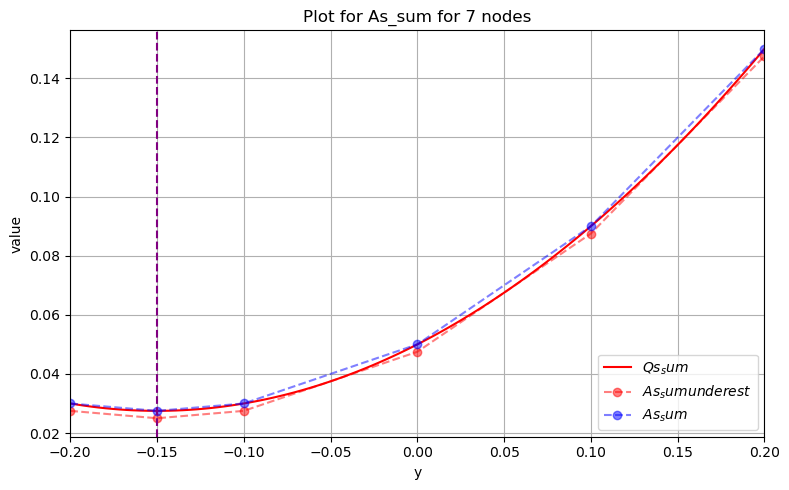

*****************************************
error at y_star is  0.0
y_star is  -0.15
ms_list and sum_ms is  [0.0, -0.0024999999999999745] 0.0024999999999999745
new node choosen from ms
new node is 0.05
*****************************************

##################################################
##################################################
Start adding node  8
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.15
ms is  0.0


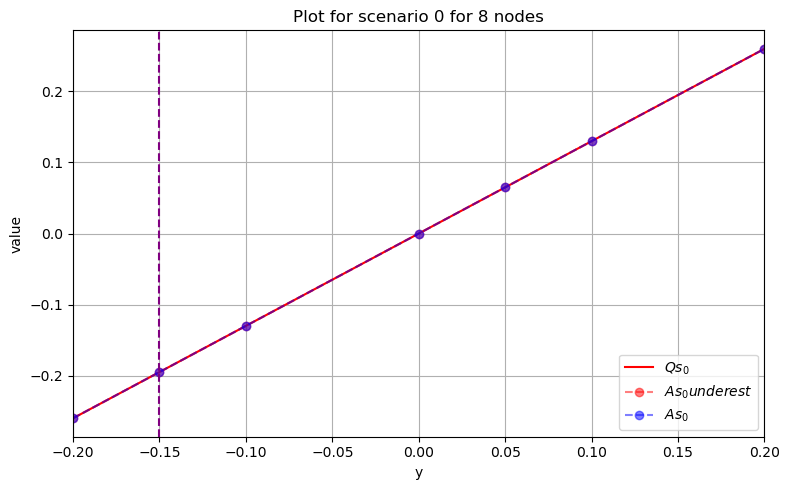

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  0.15
ms is  -0.00250000000000003


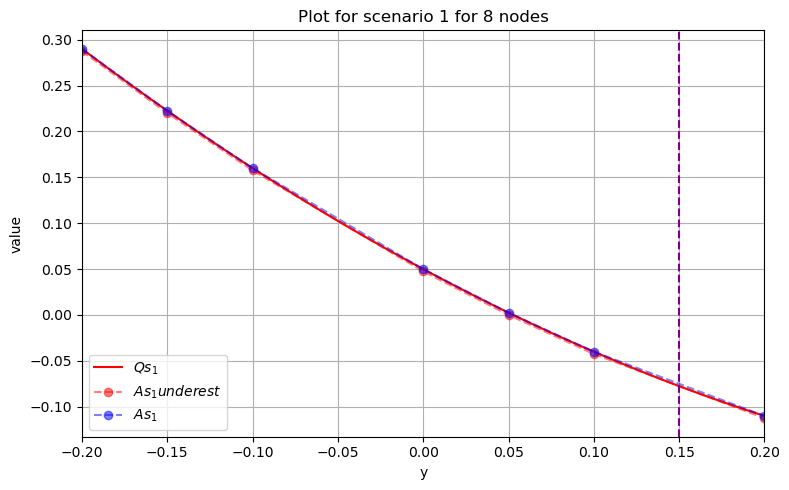

 
The plot for As_sum
The potential y_star is  -0.15
error is  0.0


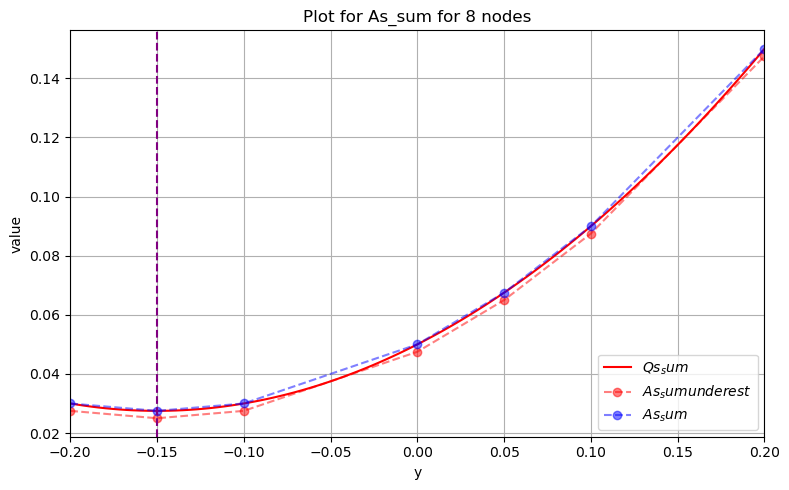

*****************************************
error at y_star is  0.0
y_star is  -0.15
ms_list and sum_ms is  [0.0, -0.00250000000000003] 0.00250000000000003
new node choosen from ms
new node is 0.15
*****************************************

##################################################
##################################################
Start adding node  9
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.15
ms is  0.0


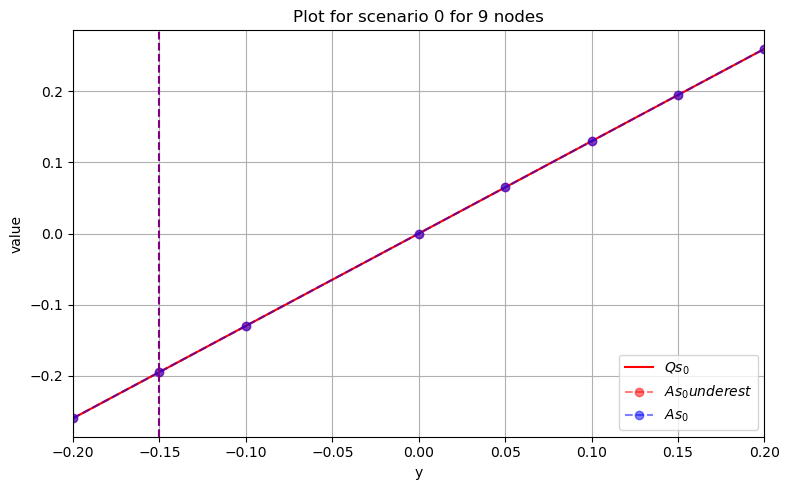

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.05
ms is  -0.002499999999999919


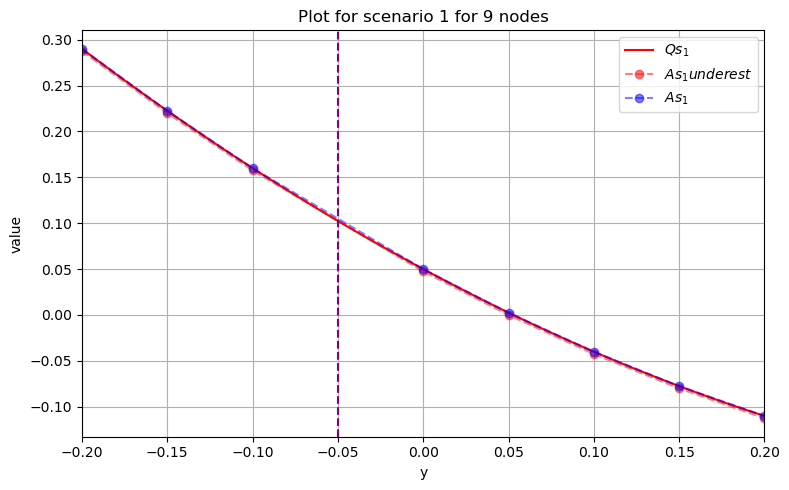

 
The plot for As_sum
The potential y_star is  -0.15
error is  0.0


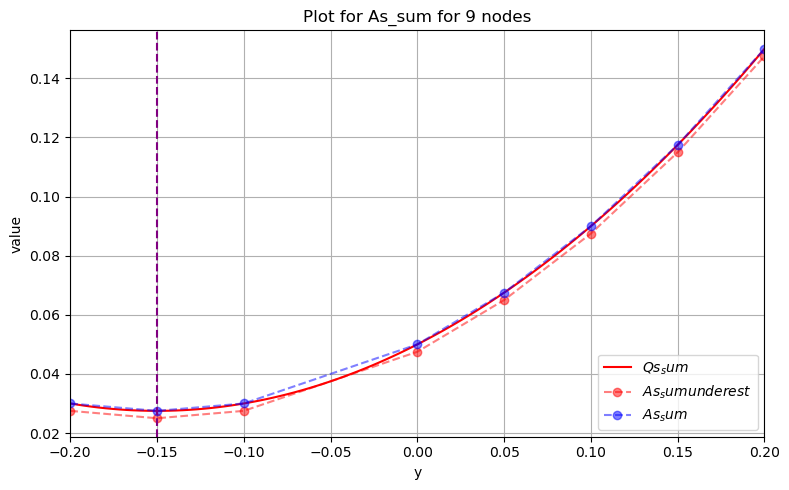

*****************************************
error at y_star is  0.0
y_star is  -0.15
ms_list and sum_ms is  [0.0, -0.002499999999999919] 0.002499999999999919
new node choosen from ms
new node is -0.05
*****************************************

##################################################
##################################################
Start adding node  10
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.15
ms is  0.0


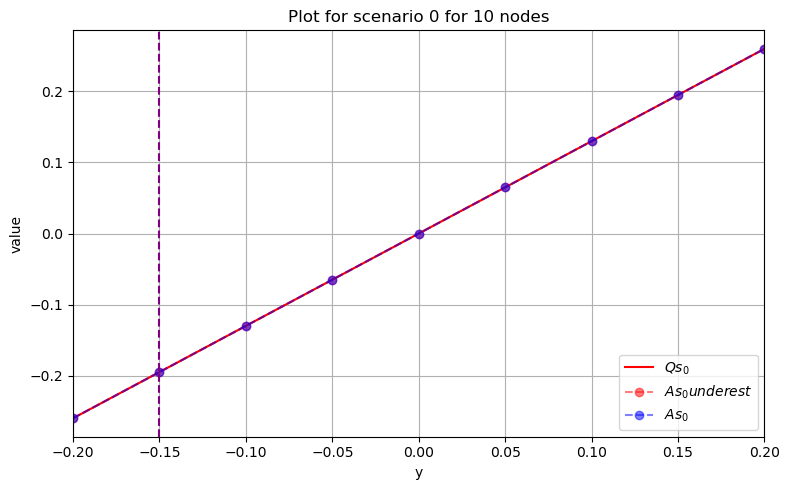

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.1749999999999987
ms is  -0.0006249999999999867


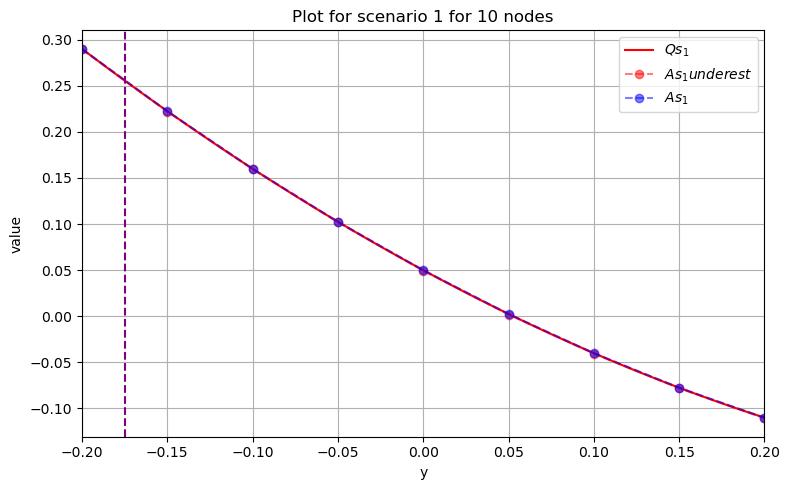

 
The plot for As_sum
The potential y_star is  -0.15
error is  0.0


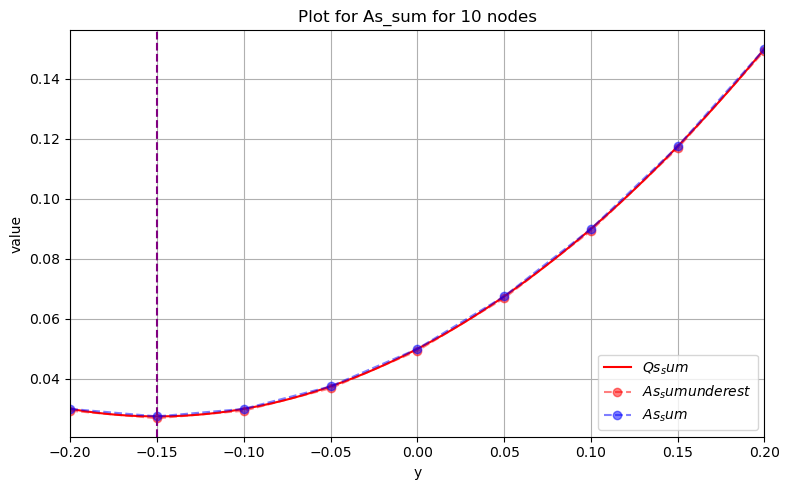

*****************************************
error at y_star is  0.0
y_star is  -0.15
ms_list and sum_ms is  [0.0, -0.0006249999999999867] 0.0006249999999999867
new node choosen from ms
new node is -0.1749999999999987
*****************************************

##################################################
##################################################
Start adding node  11
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.1749999999999987
ms is  0.0


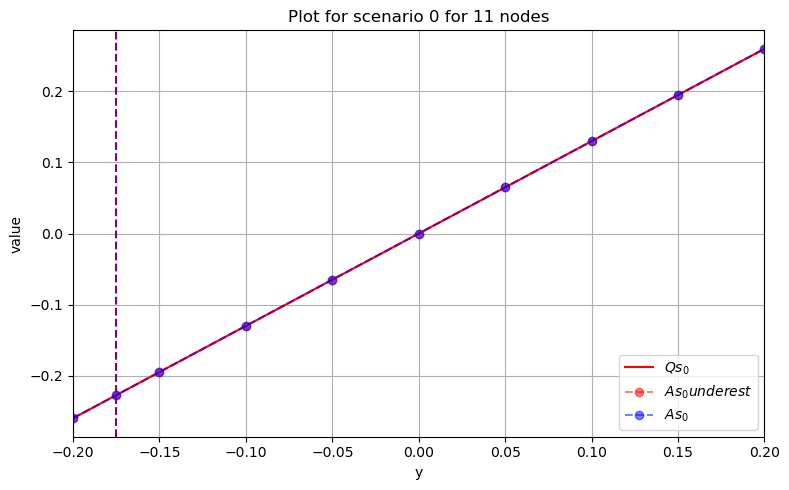

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  0.12499999999999944
ms is  -0.0006250000000000075


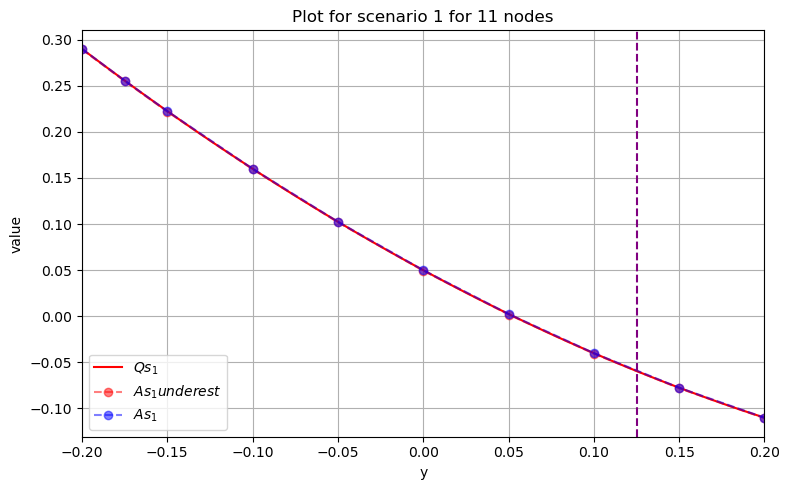

 
The plot for As_sum
The potential y_star is  -0.15
error is  0.0


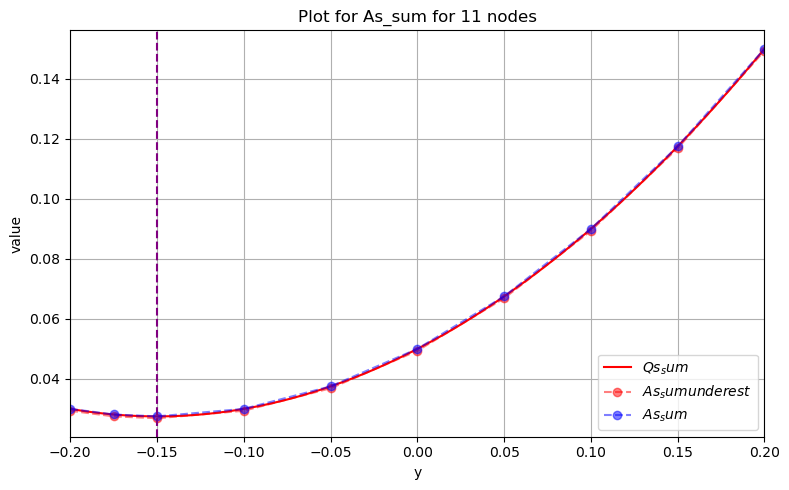

*****************************************
error at y_star is  0.0
y_star is  -0.15
ms_list and sum_ms is  [0.0, -0.0006250000000000075] 0.0006250000000000075
new node choosen from ms
new node is 0.12499999999999944
*****************************************

##################################################
##################################################
Start adding node  12
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.1749999999999987
ms is  0.0


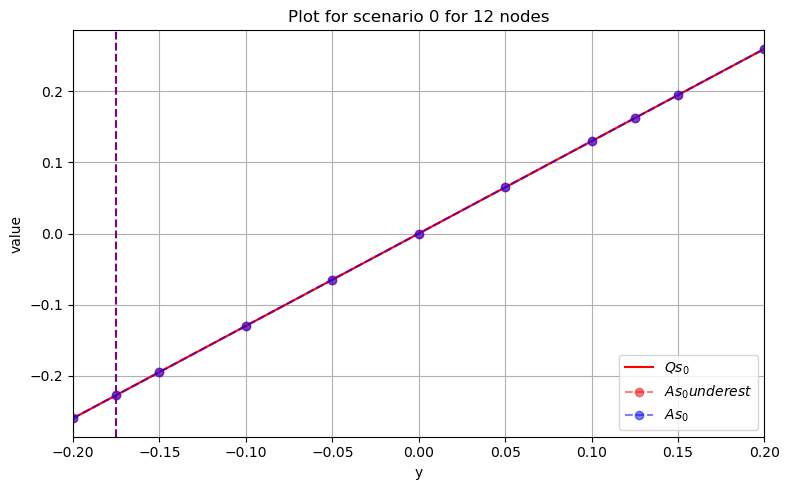

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.025000000000001577
ms is  -0.0006249999999999589


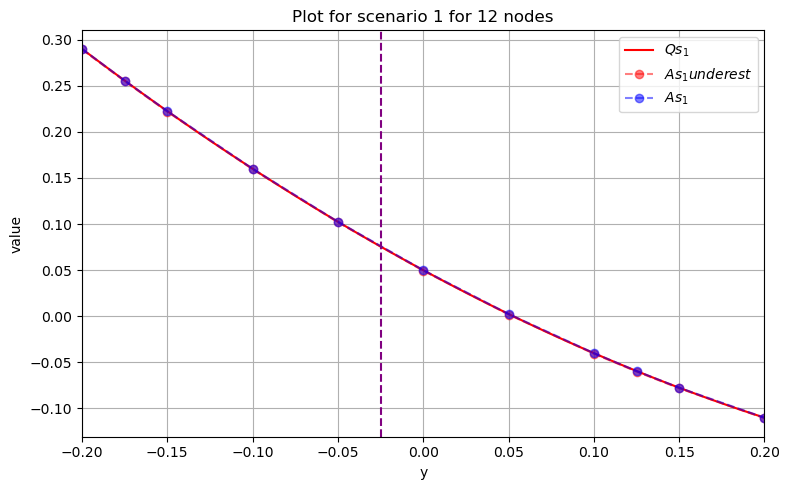

 
The plot for As_sum
The potential y_star is  -0.15
error is  0.0


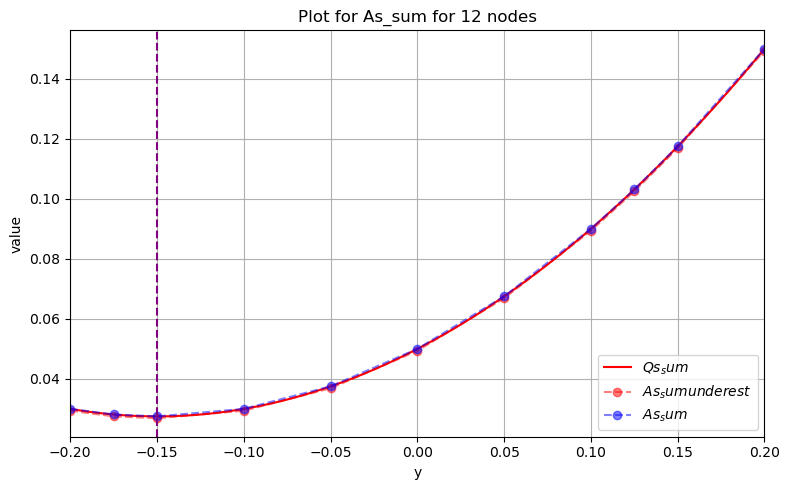

*****************************************
error at y_star is  0.0
y_star is  -0.15
ms_list and sum_ms is  [0.0, -0.0006249999999999589] 0.0006249999999999589
new node choosen from ms
new node is -0.025000000000001577
*****************************************

##################################################
##################################################
Start adding node  13
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.1749999999999987
ms is  0.0


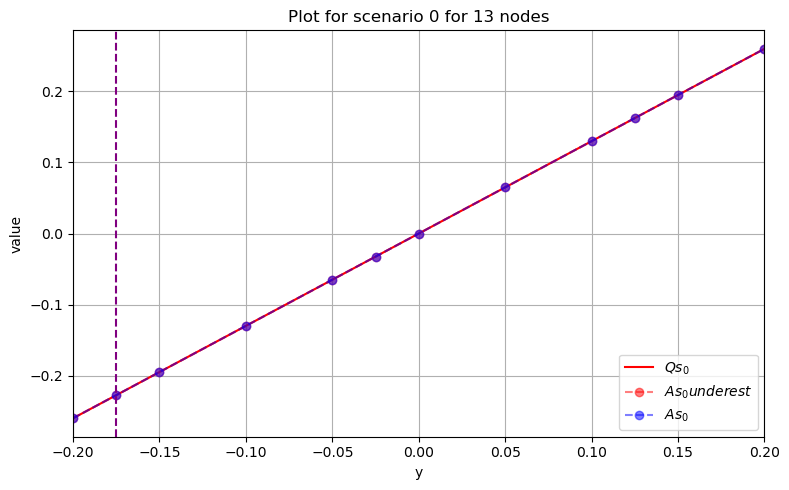

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  0.1750000000000002
ms is  -0.0006249999999999867


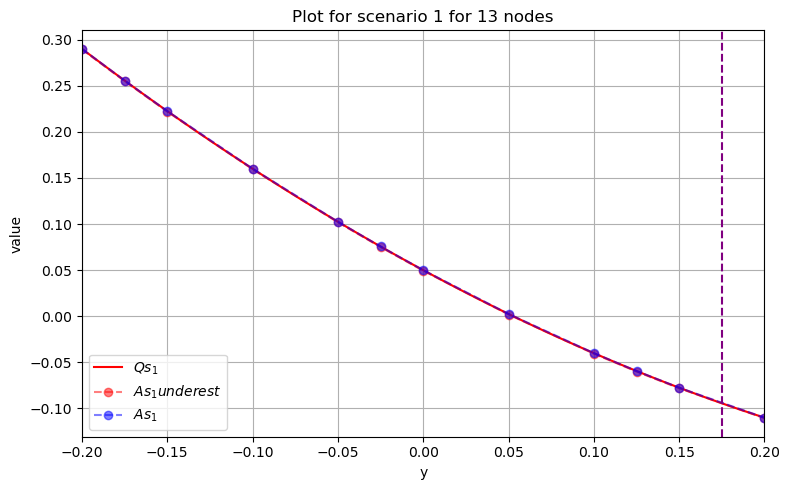

 
The plot for As_sum
The potential y_star is  -0.15
error is  0.0


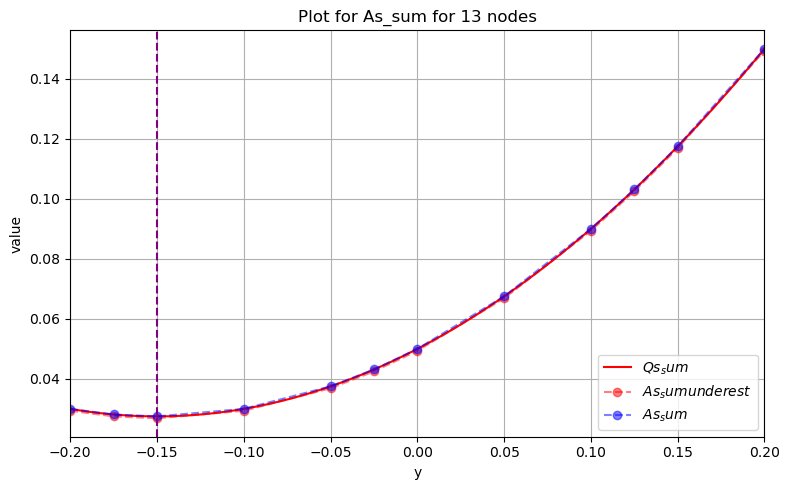

*****************************************
error at y_star is  0.0
y_star is  -0.15
ms_list and sum_ms is  [0.0, -0.0006249999999999867] 0.0006249999999999867
new node choosen from ms
new node is 0.1750000000000002
*****************************************

##################################################
##################################################
Start adding node  14
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.1749999999999987
ms is  0.0


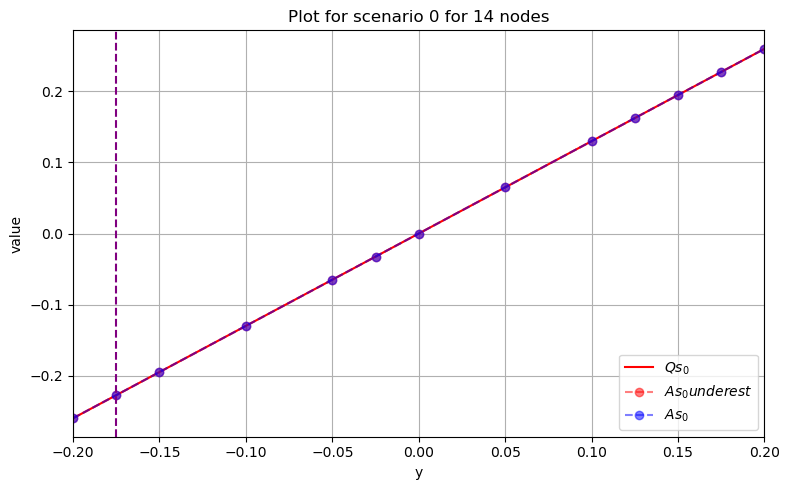

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.12500000000000067
ms is  -0.0006250000000000144


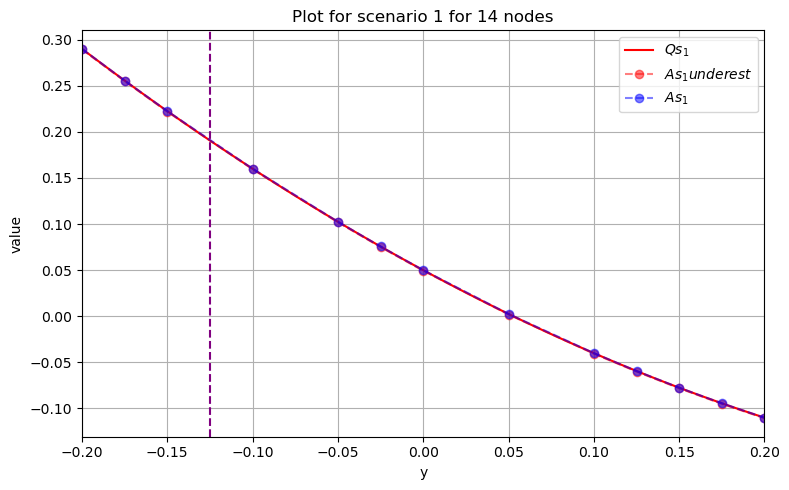

 
The plot for As_sum
The potential y_star is  -0.15
error is  0.0


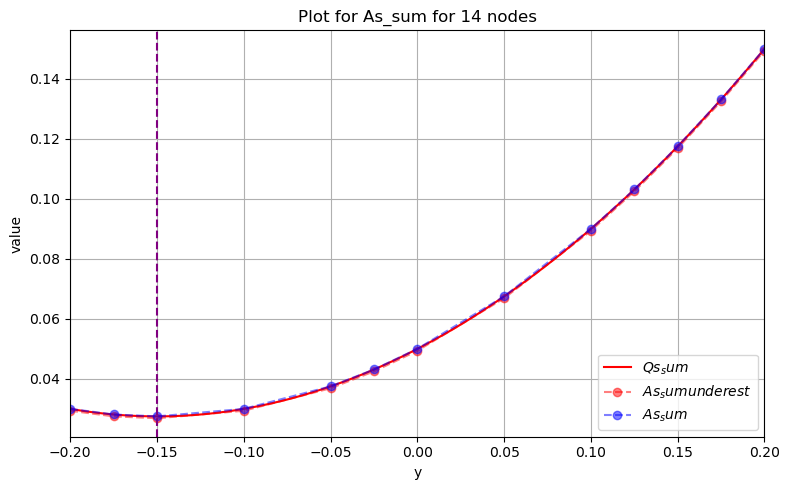

*****************************************
error at y_star is  0.0
y_star is  -0.15
ms_list and sum_ms is  [0.0, -0.0006250000000000144] 0.0006250000000000144
new node choosen from ms
new node is -0.12500000000000067
*****************************************

##################################################
##################################################
Start adding node  15
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.1749999999999987
ms is  0.0


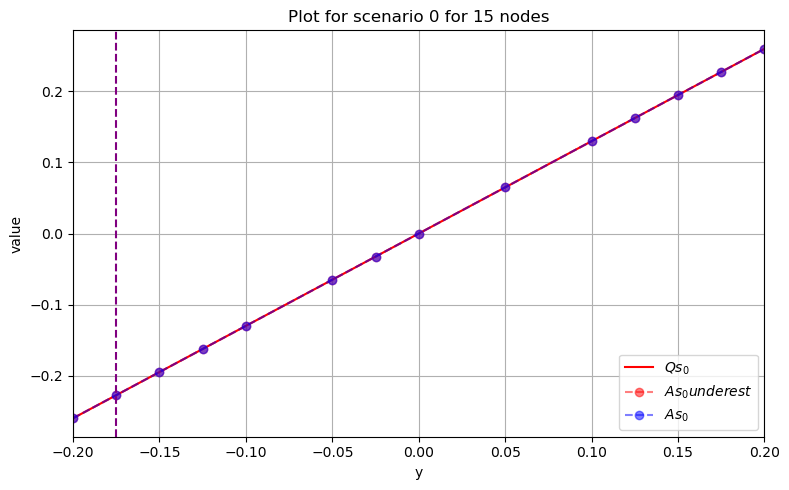

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  0.025000000000001243
ms is  -0.000624999999999945


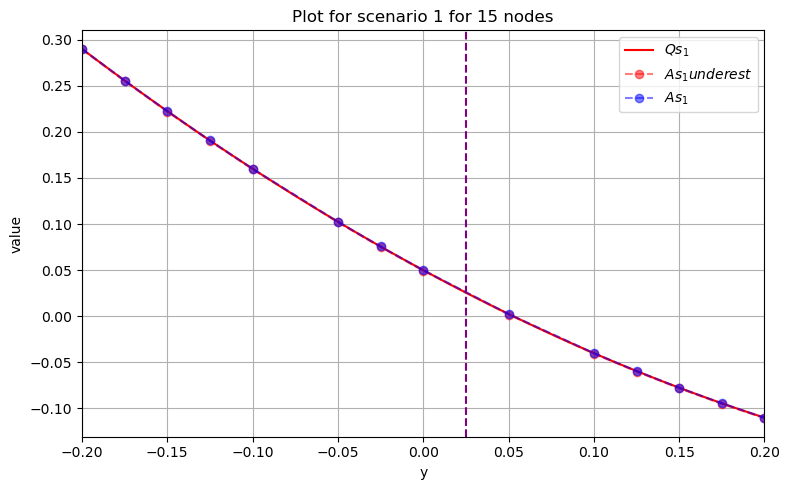

 
The plot for As_sum
The potential y_star is  -0.15
error is  0.0


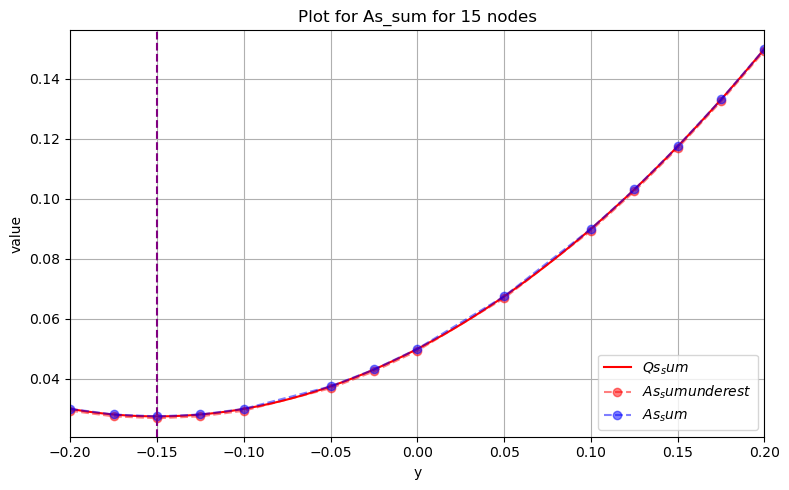

*****************************************
error at y_star is  0.0
y_star is  -0.15
ms_list and sum_ms is  [0.0, -0.000624999999999945] 0.000624999999999945
new node choosen from ms
new node is 0.025000000000001243
*****************************************

##################################################
##################################################
Start adding node  16
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.1749999999999987
ms is  0.0


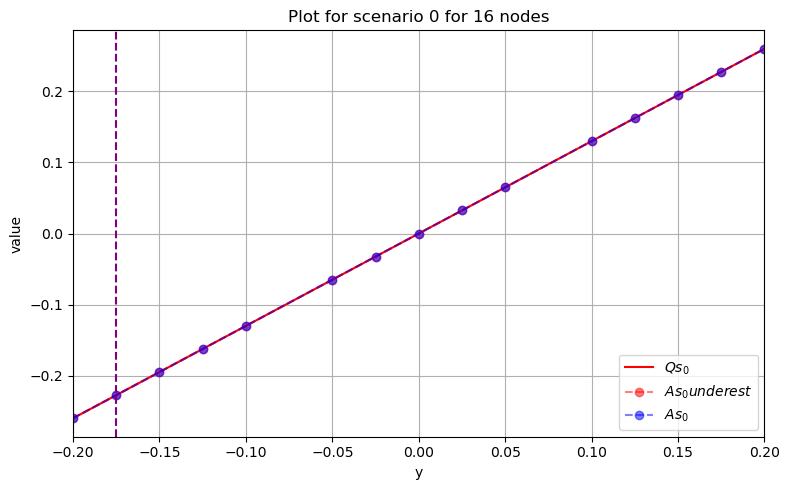

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  0.07500000000000018
ms is  -0.0006250000000000352


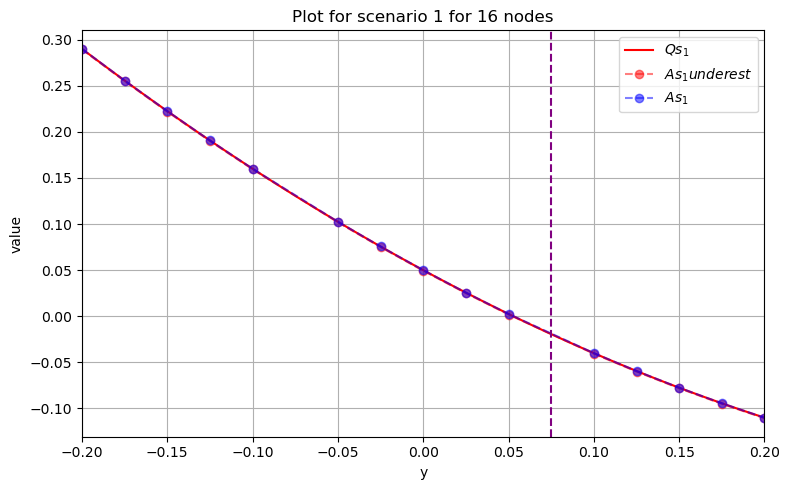

 
The plot for As_sum
The potential y_star is  -0.15
error is  0.0


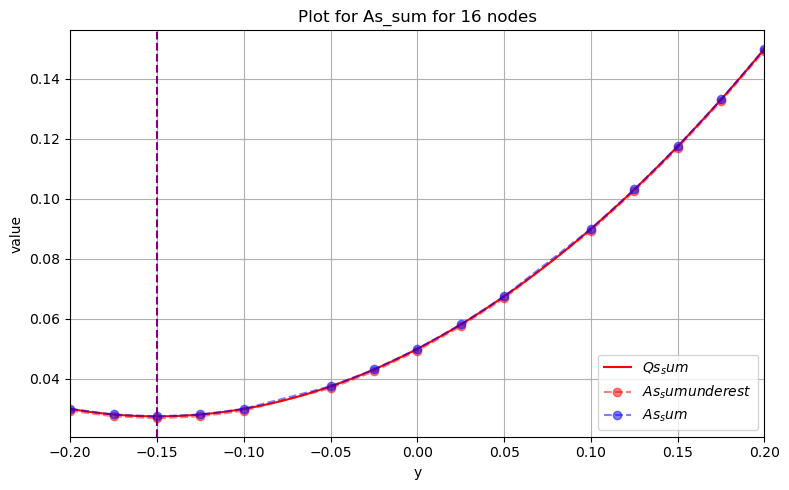

*****************************************
error at y_star is  0.0
y_star is  -0.15
ms_list and sum_ms is  [0.0, -0.0006250000000000352] 0.0006250000000000352
new node choosen from ms
new node is 0.07500000000000018
*****************************************

##################################################
##################################################
Start adding node  17
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.1749999999999987
ms is  0.0


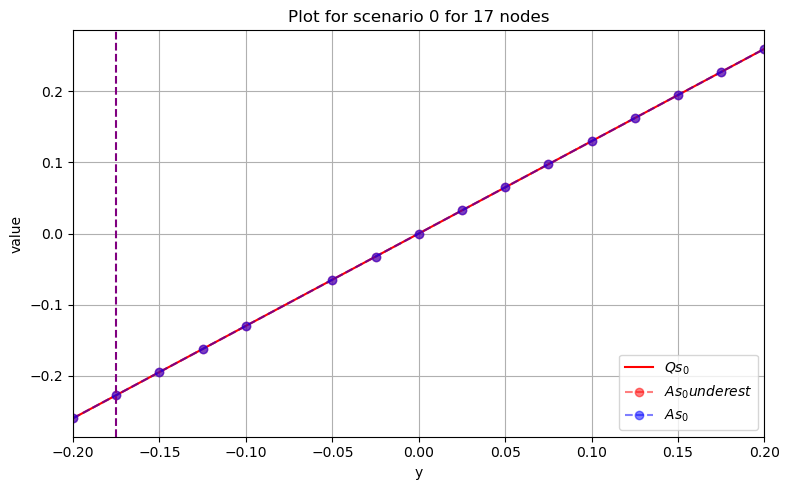

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.0749999999999994
ms is  -0.0006249999999999867


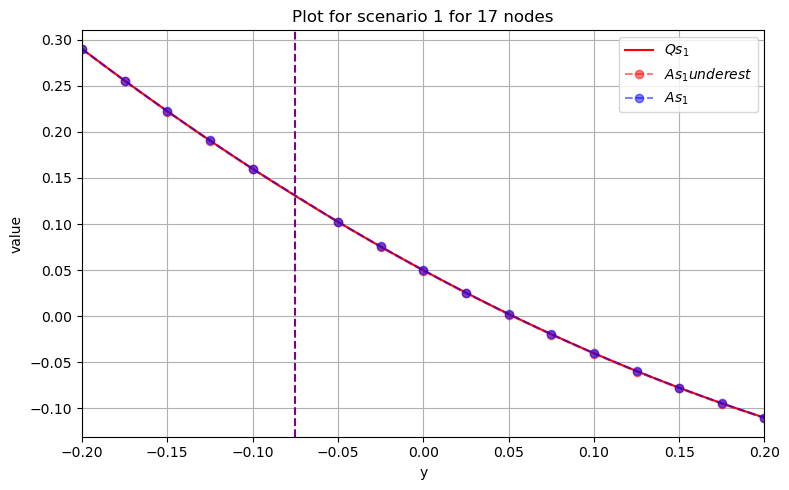

 
The plot for As_sum
The potential y_star is  -0.15
error is  0.0


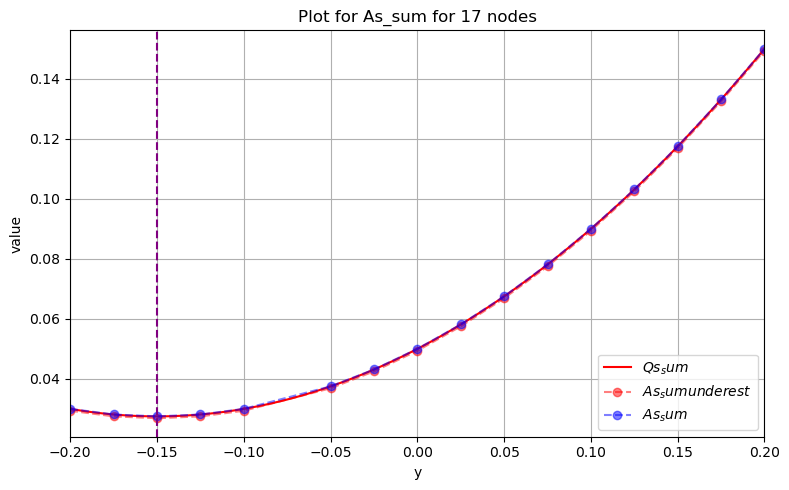

*****************************************
error at y_star is  0.0
y_star is  -0.15
ms_list and sum_ms is  [0.0, -0.0006249999999999867] 0.0006249999999999867
new node choosen from ms
new node is -0.0749999999999994
*****************************************

##################################################
##################################################
Start adding node  18
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.1749999999999987
ms is  0.0


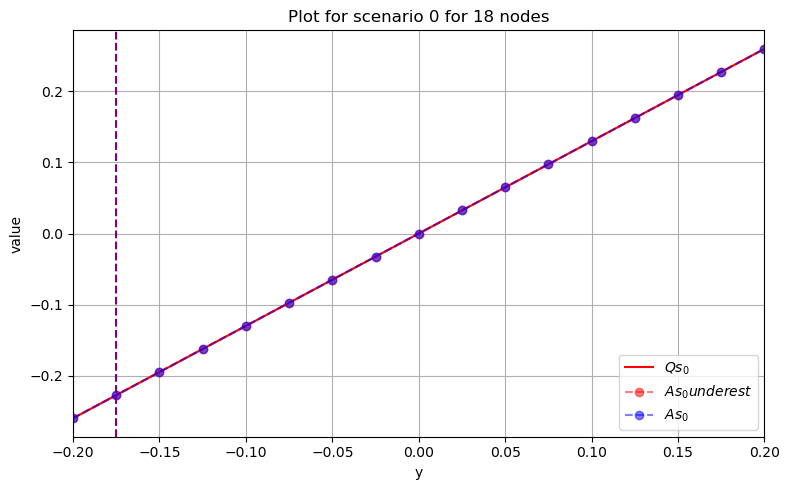

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.1874999999999981
ms is  -0.00015624999999996891


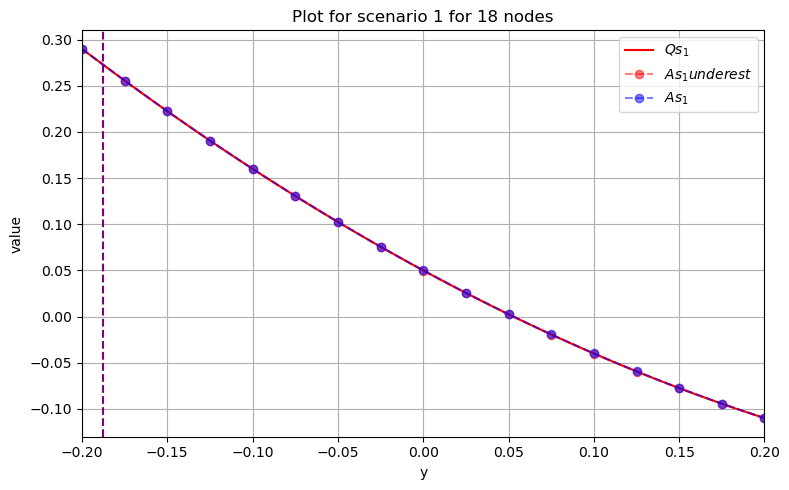

 
The plot for As_sum
The potential y_star is  -0.15
error is  0.0


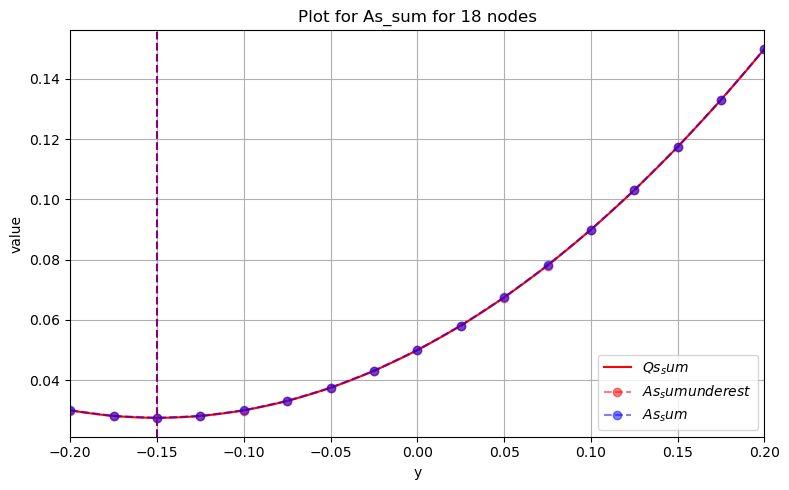

*****************************************
error at y_star is  0.0
y_star is  -0.15
ms_list and sum_ms is  [0.0, -0.00015624999999996891] 0.00015624999999996891
new node choosen from ms
new node is -0.1874999999999981
*****************************************

##################################################
##################################################
Start adding node  19
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.1874999999999981
ms is  0.0


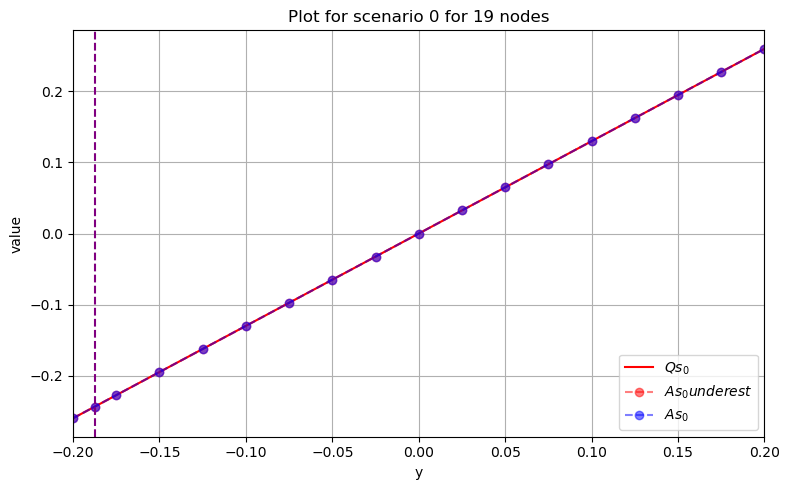

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  0.16250000000000048
ms is  -0.0001562499999999828


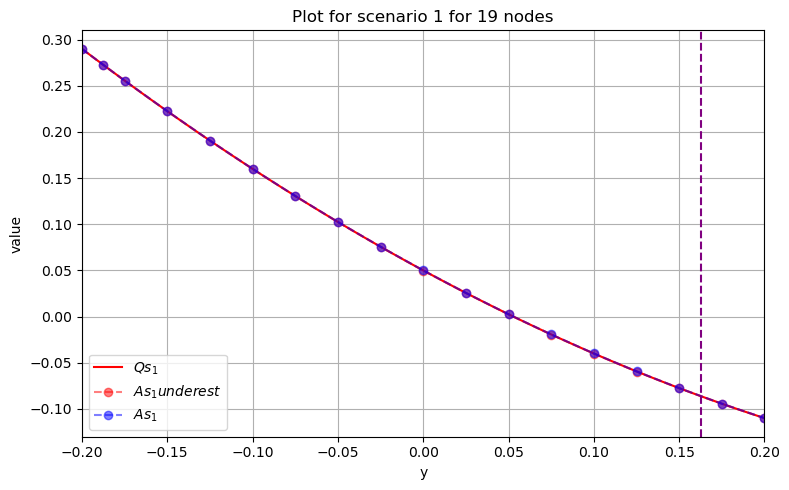

 
The plot for As_sum
The potential y_star is  -0.15
error is  0.0


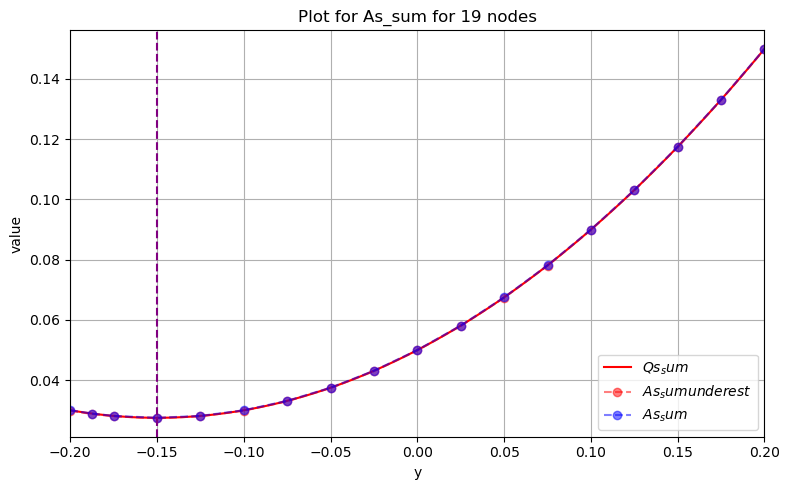

*****************************************
error at y_star is  0.0
y_star is  -0.15
ms_list and sum_ms is  [0.0, -0.0001562499999999828] 0.0001562499999999828
new node choosen from ms
new node is 0.16250000000000048
*****************************************

##################################################
##################################################
Start adding node  20
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.1874999999999981
ms is  0.0


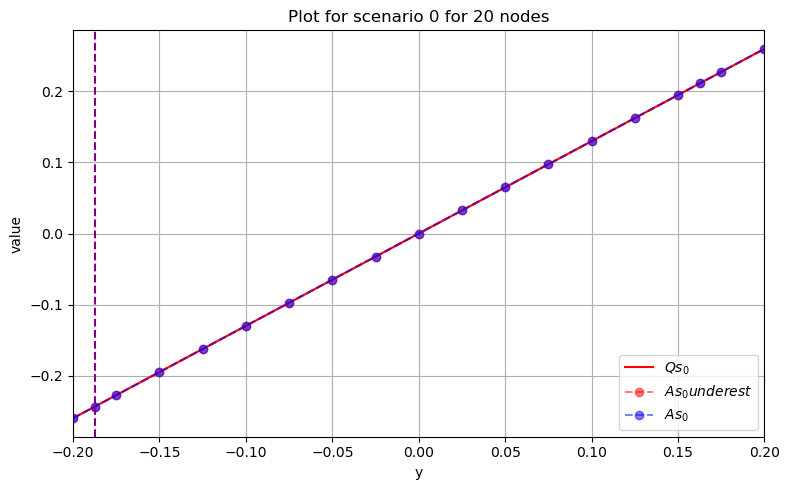

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  0.06249999999999961
ms is  -0.00015625000000001055


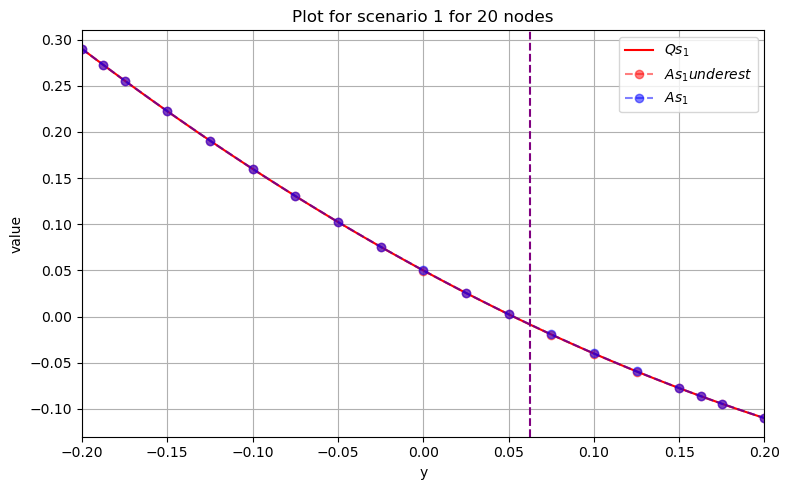

 
The plot for As_sum
The potential y_star is  -0.15
error is  0.0


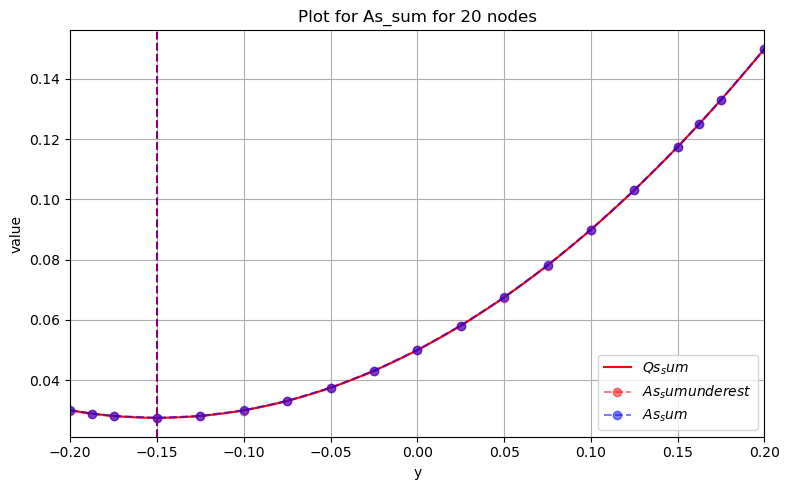

*****************************************
error at y_star is  0.0
y_star is  -0.15
ms_list and sum_ms is  [0.0, -0.00015625000000001055] 0.00015625000000001055
new node choosen from ms
new node is 0.06249999999999961
*****************************************



In [3]:
# build function for each scenario
def v_1(y):  
    return 1.3*y

def v_2(y): 
    return (y-0.5)**2-0.2

v_list = [v_1, v_2]

# lower bound and upper bound
ylb = -0.2
yub = 0.2
# build model for each scenario 
m1 = ConcreteModel()
m1.y = Var(bounds=(ylb, yub))
m1.x1 = Var()
m1.c1 = Constraint(expr=m1.x1 == m1.y)
m1.obj_expr = Expression(expr=1.3*m1.x1)

m2 = ConcreteModel()
m2.y = Var(bounds=(ylb, yub))
m2.x2 = Var()
m2.c1 = Constraint(expr=m2.x2 == (m2.y-0.5)**2)
m2.obj_expr = Expression(expr=m2.x2-0.2)

model_list = [m1, m2]

# make delta list
adds = np.arange(3, 8)
result = nc_underest([ylb, yub],model_list,20,True, v_list)

In [9]:
def v_1(y):  
    return 1.3*y

def v_2(y): 
    return (y-0.5)**2-0.2
solver = SolverFactory('gurobi')
solver.options['FeasibilityTol'] = 1e-09
solver.options['OptimalityTol'] = 1e-09
solver.options['NonConvex'] = 2 

m1 = ConcreteModel()
m1.y = Var(bounds=(ylb, yub))
m1.obj = Expression(expr=1.3*m1.y+(m1.y-0.5)**2-0.2)
results = solver.solve(m1)
print(results.problem.lower_bound)


1.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


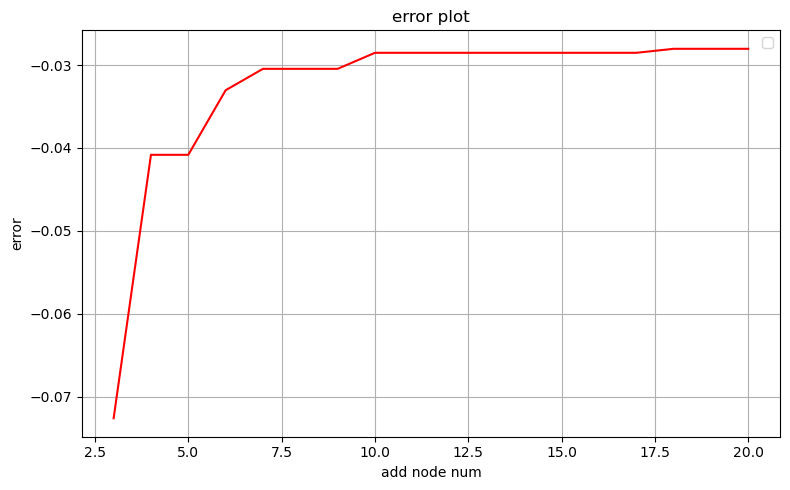

      adds     errors
----------------------
         3 0.930000000000
         4 0.960000000000
         5 0.960000000000
         6 0.967500000000
         7 0.970000000000
         8 0.970000000000
         9 0.970000000000
        10 0.971875000000
        11 0.971875000000
        12 0.971875000000
        13 0.971875000000
        14 0.971875000000
        15 0.971875000000
        16 0.971875000000
        17 0.971875000000
        18 0.972343750000
        19 0.972343750000
        20 0.972343750000


In [10]:
adds = result[-1][0]
true_min_val = 1
plt.figure(figsize=(8, 5))
errors = [true_min_val-item for item in result[-1][1]]
plt.plot(adds, np.log(errors), color='red')
plt.xlabel('add node num')
plt.ylabel('error')
plt.title(f"error plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"{'adds':>10} {'errors':>10}")
print("-" * 22)

for a, e in zip(adds, errors):
    print(f"{a:>10} {e:>10.12f}")

In [27]:
d_list = [1,1e-1,1e-2,1e-3,1e-4,1e-5]
e_list = []
for d in d_list:
    result = nc_underest([-d, d],model_list,30,False, v_list)
    e_list.append(-result[1])

WARNING (W1002): Setting Var 'y' to a numeric value `-1` outside the bounds
(-1e-05, 1e-05).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'y' to a numeric value `1` outside the bounds
(-1e-05, 1e-05).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
The goal is to get  30  nodes
##################################################
##################################################
Start adding node  3
 
Solving scenario  0
*****************************************
error at y_star is  0.5
y_star is  0.0
ms_list and sum_ms is  [-0.5] 0.5
new node choosen from ms
new node is -0.0
*****************************************

##################################################
##################################################
Start adding node  4
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-0.125] 0.125
new node choosen from ms
new node is

##################################################
##################################################
Start adding node  25
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-0.001953125] 0.001953125
new node choosen from ms
new node is -0.6875
*****************************************

##################################################
##################################################
Start adding node  26
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-0.001953125] 0.001953125
new node choosen from ms
new node is 0.6875
*****************************************

##################################################
##################################################
Start adding node  27
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-0.001953125] 0.0019

*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-1.9531249999999584e-05] 1.9531249999999584e-05
new node choosen from ms
new node is -0.09375000000000004
*****************************************

##################################################
##################################################
Start adding node  19
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-1.9531250000000017e-05] 1.9531250000000017e-05
new node choosen from ms
new node is 0.08125000000000006
*****************************************

##################################################
##################################################
Start adding node  20
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-1.953125000000045e-05] 1.953125000000045e-05
new node choosen from ms
new node is 0.09375000000

##################################################
##################################################
Start adding node  12
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-7.81250000000002e-07] 7.81250000000002e-07
new node choosen from ms
new node is 0.008749999999999999
*****************************************

##################################################
##################################################
Start adding node  13
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-7.812500000000004e-07] 7.812500000000004e-07
new node choosen from ms
new node is -0.0037500000000000003
*****************************************

##################################################
##################################################
Start adding node  14
 
Solving scenario  0
*****************************************
error at y_star 

*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-1.25e-07] 1.25e-07
new node choosen from ms
new node is 0.0005
*****************************************

##################################################
##################################################
Start adding node  6
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-3.1249999999999965e-08] 3.1249999999999965e-08
new node choosen from ms
new node is -0.00075
*****************************************

##################################################
##################################################
Start adding node  7
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-3.125e-08] 3.125e-08
new node choosen from ms
new node is 0.00025
*****************************************

#########################################

##################################################
##################################################
Start adding node  27
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-1.953125e-09] 1.953125e-09
new node choosen from ms
new node is 6.25e-05
*****************************************

##################################################
##################################################
Start adding node  28
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-1.953124999999998e-09] 1.953124999999998e-09
new node choosen from ms
new node is -0.0001875
*****************************************

##################################################
##################################################
Start adding node  29
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_m

*****************************************
error at y_star is  0.0
y_star is  -5e-05
ms_list and sum_ms is  [0.0] 0.0
new node choosen from ms
new node is -0.0001
*****************************************

##################################################
##################################################
Start adding node  22
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  -5e-05
ms_list and sum_ms is  [0.0] 0.0
new node choosen from ms
new node is -0.0001
*****************************************

##################################################
##################################################
Start adding node  23
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  -5e-05
ms_list and sum_ms is  [0.0] 0.0
new node choosen from ms
new node is -0.0001
*****************************************

##################################################
##########################################

*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [0.0] 0.0
new node choosen from ms
new node is 0.0
*****************************************

##################################################
##################################################
Start adding node  18
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [0.0] 0.0
new node choosen from ms
new node is 0.0
*****************************************

##################################################
##################################################
Start adding node  19
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [0.0] 0.0
new node choosen from ms
new node is 0.0
*****************************************

##################################################
##################################################
Start adding

C:\Users\pc\AppData\Local\Temp\ipykernel_116288\4161946405.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(d_list), np.log(e_list), color='red')
C:\Users\pc\AppData\Local\Temp\ipykernel_116288\4161946405.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(d_list), np.log(e_list), color='red')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


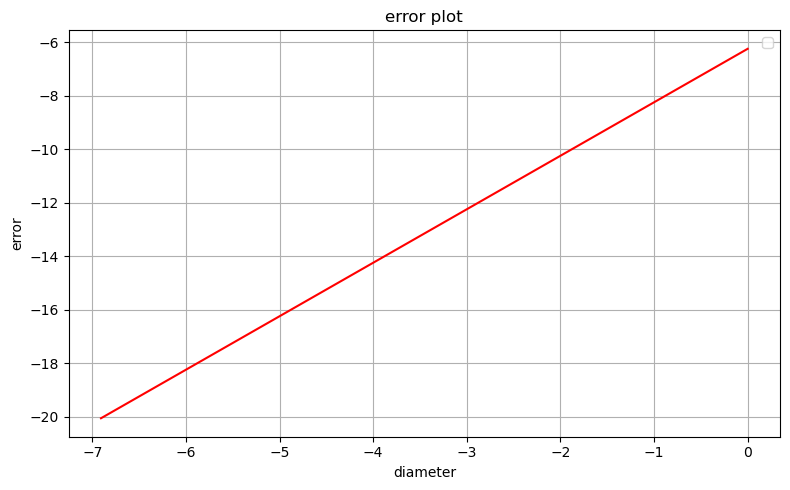

  diameter     errors
----------------------
         1 0.0019531250000000
       0.1 0.0000195312500000
      0.01 0.0000001953125000
     0.001 0.0000000019531250
    0.0001 -0.0000000012500000
     1e-05 -0.0000000000000000


In [29]:
plt.figure(figsize=(8, 5))
plt.plot(np.log(d_list), np.log(e_list), color='red')
plt.xlabel('diameter')
plt.ylabel('error')
plt.title(f"error plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"{'diameter':>10} {'errors':>10}")
print("-" * 22)

for a, e in zip(d_list, e_list):
    print(f"{a:>10} {e:>10.16f}")